# Librerias

In [1]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import sklearn as sk



#modelos y métricas
import pickle
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

#hiperparametros
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV , cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer


#configuración warnings
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Importación de datasets

In [2]:
url_train = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/checkpoint-2/checkpoint-2/hotels-train.csv'
url_test = 'https://raw.githubusercontent.com/FrancoSecchi/7506R-1C2023-GRUPO02/checkpoint-2/checkpoint-2/hotels-test.csv'
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)

In [3]:
df_hotels_train = df_train.copy()
df_hotels_test = df_test.copy()

In [4]:
df_hotels_train.columns.to_list()

['Unnamed: 0',
 'hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status_date',
 'id',
 'is_canceled']

In [5]:
df_hotels_train.drop(columns=['Unnamed: 0'], inplace=True)
df_hotels_test.drop(columns=['Unnamed: 0'], inplace=True)

# Funciones

In [6]:
def train_with_cv(params, folds, x_train, y_train):
  # Spits que respeten la proporción de las clases
  kfoldcv = StratifiedKFold(n_splits=folds) 
  
  #Creo árbol con los mejores hiperparámetros 
  arbolcv=DecisionTreeClassifier().set_params(**params)

  #Selecciono métrica F1-Score
  scorer_fn = make_scorer(sk.metrics.f1_score)

  #Hago CV
  resultados = cross_validate(arbolcv,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)

  metricsCV=resultados['test_score']
  return resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]

In [7]:
def cramers_v(categorical_var1: pd.Series, categorical_var2: pd.Series) -> float:
    """
    Calcula el coeficiente de Cramér's V entre dos variables categóricas.

    Parámetros:
    - categorical_var1: Serie de Pandas que representa la primera variable categórica.
    - categorical_var2: Serie de Pandas que representa la segunda variable categórica.

    Devuelve:
    - Coeficiente de Cramér's V (float) que mide la asociación entre las dos variables categóricas.
    """

    confusion_matrix = pd.crosstab(categorical_var1,categorical_var2)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [8]:
# Funcion que reemplaza la variable "reservation_status_date" por una version numerica de si misma y la dropea
def replace_reservation_date(df):
  df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

  df['reservation_month'] = df['reservation_status_date'].dt.month
  df['reservation_year'] = df['reservation_status_date'].dt.year
  df['reservation_day'] = df['reservation_status_date'].dt.day

  df.drop(['reservation_status_date'], axis=1, inplace=True)

In [9]:
# Imprimimos el arbol

from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

def graph_tree(tree):
  dot_data = StringIO()
  export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                max_depth=4,
                class_names=['canceled','not_canceled'])

  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
  return Image(graph.create_png())

In [10]:
def show_performance(y_test, y_pred):
  print(f"F1 Score: {f1_score(y_test, y_pred, average='binary')}")
  print(f"Classification Report: \n {classification_report(y_test, y_pred)}")
  matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(matrix, cmap='Greens', annot=True, fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

# Feature Engineering - Transformación de Datos

### Imputación previa al analisis
> Antes de empezar con la ingenieria de datos, procedemos a borrar algunas filas (poca cantidad) que contienen datos no coherentes con lo reflejado en el dataset de test

In [11]:
before = df_hotels_train.shape[0]
undefined_rows = df_hotels_train[(df_hotels_train['market_segment'] == 'Undefined') | (df_hotels_train['distribution_channel'] == 'Undefined')].index
df_hotels_train.drop(undefined_rows, inplace=True)

In [12]:
print(f"diff: {before - df_hotels_train.shape[0]}")
before, df_hotels_train.shape[0]

diff: 4


(59481, 59477)

### **Columnas Droppeadas - Analisis de Correlación y Relevancia**

- Para ayudar a nuestra decision sobre que columnas droppear, observamos su nivel de correlacion con la variable target (is_canceled), ademas de esto tomaremos en cuenta si creemos que pueda aportar informacion valiosa para determinar si el cliente cancela la orden.



In [13]:
# Correlacion de variables numericas
df_hotels_train.corr()['is_canceled'].abs().sort_values(ascending = False)

is_canceled                       1.000000
lead_time                         0.285720
total_of_special_requests         0.235472
required_car_parking_spaces       0.222223
booking_changes                   0.154333
previous_cancellations            0.137635
is_repeated_guest                 0.087748
previous_bookings_not_canceled    0.065774
adults                            0.059340
days_in_waiting_list              0.057154
adr                               0.049087
babies                            0.031654
stays_in_week_nights              0.030179
arrival_date_year                 0.017984
stays_in_weekend_nights           0.007112
arrival_date_week_number          0.004967
arrival_date_day_of_month         0.004834
children                          0.004285
Name: is_canceled, dtype: float64

In [14]:
var_cualitative = [columna for columna in df_hotels_train.columns if not np.issubdtype(df_hotels_train[columna].dtype, np.number)]
var_cualitative.append('is_canceled')
var_cualitative.remove('id')

In [15]:
df_hotels_train_copy = df_hotels_train.copy()
df_hotels_train_copy.loc[df_hotels_train_copy.loc[:,"is_canceled"]==1,"is_canceled"] = "Si"
df_hotels_train_copy.loc[df_hotels_train_copy.loc[:,"is_canceled"]==0,"is_canceled"] = "No"

result = {}
corr_matrix = np.zeros((len(var_cualitative), len(var_cualitative)))

for i, var1 in enumerate(var_cualitative):
    for j, var2 in enumerate(var_cualitative):
        corr_matrix[i, j] = cramers_v(df_hotels_train_copy[var1], df_hotels_train_copy[var2])
        result[var1] = corr_matrix[i, j]

cualitative_corr = pd.Series(result).abs().sort_values(ascending=False)

In [16]:
# Correlacion variables cualitativas
cualitative_corr

is_canceled                0.999966
reservation_status_date    0.469886
deposit_type               0.432787
market_segment             0.266828
assigned_room_type         0.208443
distribution_channel       0.191301
hotel                      0.144083
customer_type              0.141229
arrival_date_month         0.073367
reserved_room_type         0.066835
meal                       0.039756
dtype: float64

#### **Variables Cuantitativas a Borrar**

- arrival_date_year: 
> El año en que la persona llega al hotel no deberia influir mucho, ya que no hay un año con niveles de cancelaciones mas alto que otros, este feature no aporta mas valor que por ejemplo el numero de semana o mes del año de cuando se hospeda el cliente.

- days_in_waiting_list:
> Ademas de tener un nivel de correlacion bajo, el numero de dias en la lista de espera cuenta la diferencia de dias entre el momento en que la reserva fue creada en la DB del hotel hasta que fuese CONFIRMADA.

- booking_changes:
> Segun el paper, un usuario que tenga muchos cambios en su booking no necesariamente implica que vaya a cancelar la orden, en el ambito de hoteleria es muy comun que un cliente solicite cambios a medida que avanza su estadia.

- arrival_date_month:
> Esta variable ya es deducible con el "arrival_week_number", por ende nos parece que esta redundante en el modelo y solo le facilitaria al arbol para hacer preguntas mas especificas.


#### **Variables Categóricas a Borrar**
- assigned_room_type:
> Representa solamente el codigo de la habitacion asignada al usuario, esta variable suele ser igual a la habitacion reservada, sin embargo si difiere es mas que todo por peticion del usuario y/o niveles de disponibilidad del hotel informacion que esta mejor represantada en el campo `booking_changes`.
- meal:
> No consideramos que tenga una mayor correlacion con una decision sobre cancelar o no una reserva, simplemente representa el tipo de comida que reserva el cliente (Debatir).

In [17]:
#Columnas no utiles
bad_cols = ['arrival_date_year','days_in_waiting_list','assigned_room_type', 'booking_changes', 'arrival_date_month']
df_hotels_train.drop(bad_cols, axis=1, inplace=True)
df_hotels_test.drop(bad_cols, axis=1, inplace=True)

## Encoding y Normalizacion - Data Preparation


In [18]:
df_curated = df_hotels_train.copy()

### **VARIABLES CUANTITATIVAS**

> Para este dataset, estaremos realizando `min-max scaling` para representar las distintas cardinalidades de las variables de una manera mas homogenea y facil de discernir para el modelo, evitando asi tener puntos de corte para condiciones que sean de cantidades muy distintas.

In [19]:
cols_numericas = [columna for columna in df_hotels_train.columns if np.issubdtype(df_hotels_train[columna].dtype, np.number)]
cols_numericas.remove('is_canceled')
cols_numericas.remove('is_repeated_guest')
cols_numericas

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [20]:
# Creamos el scaler
scaler = MinMaxScaler() 

# Alimentamos el scaler con los datos de TRAIN.
scaler.fit(pd.DataFrame(df_hotels_train[cols_numericas]))

# Aplicamos las transformaciones a el dataset de Train y al de TEST para nuestra prediccion de Kaggle.
df_curated[cols_numericas]=scaler.transform(df_curated[cols_numericas])
df_hotels_test[cols_numericas]=scaler.transform(df_hotels_test[cols_numericas])

### **VARIABLES CATEGORICAS**

> Para este dataset, estaremos encodeando para que las variables NO numericas sean aptas para ser interpretadas por el modelo.

In [21]:
cols_categoricas = [columna for columna in df_hotels_train.columns if not np.issubdtype(df_hotels_train[columna].dtype, np.number)]
df_curated[cols_categoricas].head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,reservation_status_date,id
0,City Hotel,BB,Online TA,TA/TO,D,No Deposit,Transient,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689
1,Resort Hotel,BB,Groups,Direct,A,No Deposit,Transient,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1
2,City Hotel,BB,Online TA,TA/TO,F,No Deposit,Transient,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c
3,City Hotel,BB,Groups,TA/TO,A,Non Refund,Transient,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff
4,City Hotel,BB,Offline TA/TO,TA/TO,A,No Deposit,Transient-Party,2017-03-26,28c75445-c603-413a-babf-ad377018b592


> Podemos observar que la variable `reservation_status_date` se encuentra en tipo `datetime`, para hacerlo mas amigable al modelo, procedemos a transformarlo en columnas numericas.


**NOTA: Esta variable previamente habiamos establecido que no la ibamos a tomar en cuenta, sin embargo observamos que tiene un alto nivel de correlacion con la variable target, por lo que hemos decidido tomarla en cuenta para el pre-procesamiento del dataset.**

####Transformaciones de fechas

> Acomodamos las representaciones de las variables `reservation_status_date` y `arrival_date_month`

In [22]:
#Modificamos reservation_status_date en test y train
replace_reservation_date(df_curated)
replace_reservation_date(df_hotels_test)

In [23]:
df_curated[['reservation_year','reservation_day','reservation_month']].head()

,reservation_year,reservation_day,reservation_month
0,2016,25,8
1,2015,1,11
2,2016,14,10
3,2016,29,11
4,2017,26,3


#### **ONE-HOT-ENCODING**
> Ejecucion del `one-hot-encoding` a traves de dummies para cada variable

In [24]:
# Evaluar si el reservation_year es necesario hacerle dummies.
dummy_columns = ["hotel","market_segment","distribution_channel", "reserved_room_type", "deposit_type", "customer_type", "meal"]

#Train
df_curated = pd.get_dummies(df_curated, columns=dummy_columns, drop_first=True)
#Test
df_hotels_test = pd.get_dummies(df_hotels_test, columns=dummy_columns, drop_first=True)

#### **VALORES DE HABITACION FALTANTE (IMPORTANTE)**
> En el checkpoint pasado, al borrar algunos outliers se eliminaron los casos en que se alquilaba una habitacion de tipo P, esto causa que no exista una columna dummie para el caso, por ende no matchearan las columnas en un futuro con el dataset de train. La restauraremos estando siempre con valor igual a 0.

In [25]:
loc_room_type_L = df_curated.columns.get_loc('reserved_room_type_L')
df_curated.insert(loc=loc_room_type_L+1, column='reserved_room_type_P', value=0)

In [26]:
df_curated.columns.to_list()

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'id',
 'is_canceled',
 'reservation_month',
 'reservation_year',
 'reservation_day',
 'hotel_Resort Hotel',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'reserved_room_type_B',
 'reserved_room_type_C',
 'reserved_room_type_D',
 'reserved_room_type_E',
 'reserved_room_type_F',
 'reserved_room_type_G',
 'reserved_room_type_H',
 'reserved_room_type_L',
 'reserved_room_type_P',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'customer_type_Group',
 'c

#### **LABEL ENCODING**
> Realizamos encodeo por labels a las variables categoricas.

###**ARMADO DATASET ENTRENAMIENTO**

> Nuestro dataset "curado" procedemos a splittearlo.


In [27]:
x_model = df_curated
y_model = df_hotels_train['is_canceled']
x_model.drop('id', axis=1, inplace=True)
x_model.drop('is_canceled', axis=1, inplace=True)


#Podemos ver que el numero de filas coincide.
assert(x_model.shape[0] == y_model.shape[0])
print(f"Shape del X: {x_model.shape} y Shape del Y: {y_model.shape}")

Shape del X: (59477, 44) y Shape del Y: (59477,)


In [28]:
x_model.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,reserved_room_type_L,reserved_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,meal_FB,meal_HB,meal_SC
0,0.118357,0.692308,0.133333,0.0625,0.050,0.000000,0.0,0.0,0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,0.009662,0.826923,1.000000,0.0000,0.025,0.018519,0.0,0.0,0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,0.060386,0.788462,0.400000,0.0000,0.025,0.018519,1.0,0.0,0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,0.062802,0.961538,0.366667,0.1250,0.125,0.018519,0.0,0.0,0,0.0,...,0,0,1,0,0,1,0,0,0,0
4,0.251208,0.211538,0.600000,0.1250,0.125,0.018519,0.0,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,0


### **DATA SPLIT - TRAIN Y VALIDACION**
> Con el nuevo x_model & y_model podemos ahora empezar con el split en datos de entrenamiento y validacion.

In [29]:
# Separo los features
features = x_model.columns
target = 'is_canceled' 

In [30]:
# Balanceo de Clases
y_model.value_counts(normalize=True)*100

0    50.678414
1    49.321586
Name: is_canceled, dtype: float64

In [31]:
from sklearn.pipeline import Pipeline

x_train, x_test, y_train, y_test = train_test_split(x_model, 
                                                    y_model,
                                                    test_size=0.2,
                                                    random_state=801,
                                                    stratify=y_model.values)

len(x_train) , len(x_test)

(47581, 11896)

### **HIPERPARAMETROS - BUSQUEDA**
> Con los datos ya splitteados y sanitizados, empezamos la busqueda de nuestros hiperparametros.

In [74]:
# Cantidad de combinaciones
n = 100

# Parametros a optimizar
params_grid = {
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': np.linspace(0.00010, 0.01, 50),
    'max_depth': list(range(5,15)),
    'max_features': list(range(10,25)),
    'min_samples_leaf': list(range(100,250,2))
}

# Splits para la CV
folds = 20

# Stratified KFOLD
kfoldcv = StratifiedKFold(n_splits=folds)

# Arbol Base
tree = DecisionTreeClassifier()

# Metrica a optimizar (F1 Score)
scorer = make_scorer(sk.metrics.f1_score)

# Construimos la CV
randomcv = RandomizedSearchCV(estimator = tree,
                              param_distributions = params_grid,
                              scoring = scorer,
                              n_iter = n)

# Hacemos el fit
randomcv.fit(x_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'ccp_alpha': array([0.0001    , 0.00030204, 0.00050408, 0.00070612, 0.00090816,
       0.0011102 , 0.00131224, 0.00151429, 0.00171633, 0.00191837,
       0.00212041, 0.00232245, 0.00252449, 0.00272653, 0.00292857,
       0.00313061, 0.00333265, 0.00353469, 0.00373673, 0.00393878,
       0.00414082, 0.00434286, 0.004544...
       0.00919184, 0.00939388, 0.00959592, 0.00979796, 0.01      ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14],
                                        'max_features': [10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19, 20, 21,
                                                         22, 23, 24],
                                        'min_samples_leaf': [100, 102, 104, 106,
                                                             108, 110, 112, 114,
                                                             116, 118, 120, 122,
                                                             124, 126, 128, 130,
                                                             132, 134, 136, 138,
                                                             140, 142, 144, 146,
                                                             148, 150, 152, 154,
                                                             156, 158, ...]},
                   scoring=make_scorer(f1_score))

Para la construcción del árbol de decisión, decidimos utilizar una cantidad de _folds_ de 20. 

Hay diversas métricas que nos ayudan a la hora de elegir cuales son los mejores hiperparametros, como por ejemplo _accuracy_, _f1_score_, entre otras. Nosotros elegimos guiarnos por la métrica _f1_score_.

In [75]:
# Mejores Hiperparametros
best_params = randomcv.best_params_
print(f"Mejores Parametros: {best_params}")
# Mejor Score
print(f"Mejor Score: {randomcv.best_score_}")

Mejores Parametros: {'min_samples_leaf': 110, 'max_features': 16, 'max_depth': 11, 'criterion': 'gini', 'ccp_alpha': 0.0005040816326530613}
Mejor Score: 0.7766188952064286


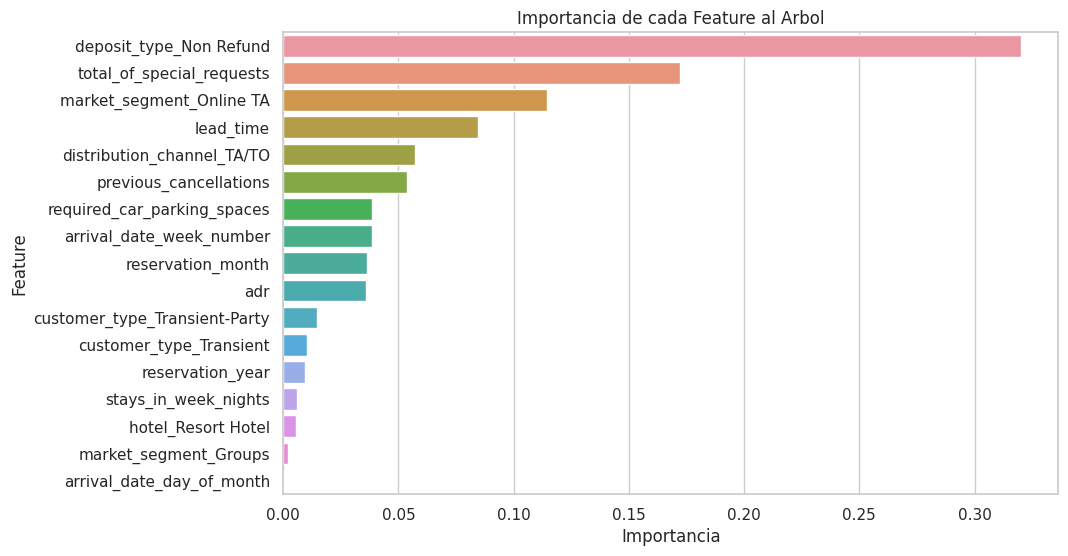

In [76]:
# Veamos la importancia de las features
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_

# create a dictionary of feature importances
feat_dict = {}
for feat_imp, feat in zip(feat_imps, features):
    if feat_imp > 0:
        feat_dict[feat] = feat_imp

# create a bar plot
feat_dict = dict(sorted(feat_dict.items(), key=lambda kv: kv[1], reverse=True))
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=list(feat_dict.values()), y=list(feat_dict.keys()))
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de cada Feature al Arbol")
plt.show()

# Clasificación - Entrenamiento

> Entrenamos un nuevo arbol sobre la totalidad de los datos, con los mejores hiperparametros obtenidos


### **Entrenando Arbol de mejores Parametros - Solo con CV**
> Haciendo uso de los mejores parametros, realizamos cross validation para entrenarlo.

In [77]:
#best_params = {"min_samples_leaf": 100, "max_features": 21, "max_depth": 12, "criterion": "entropy", "ccp_alpha": 0.0005040816326530613}

In [78]:
mejor_performance = train_with_cv(best_params, folds, x_train, y_train)

F1 Score: 0.7768845171663671
Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.90      0.82      6029
           1       0.87      0.70      0.78      5867

    accuracy                           0.80     11896
   macro avg       0.81      0.80      0.80     11896
weighted avg       0.81      0.80      0.80     11896



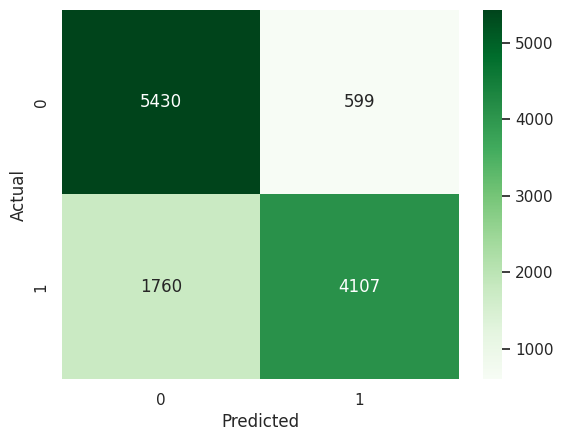

In [79]:
# Evaluamos el arbol con mejor hiperparametros y con cv
y_pred = mejor_performance.predict(x_test)

final_score = f1_score(y_test, y_pred, average='binary')
show_performance(y_test, y_pred)

# Árbol de decisión

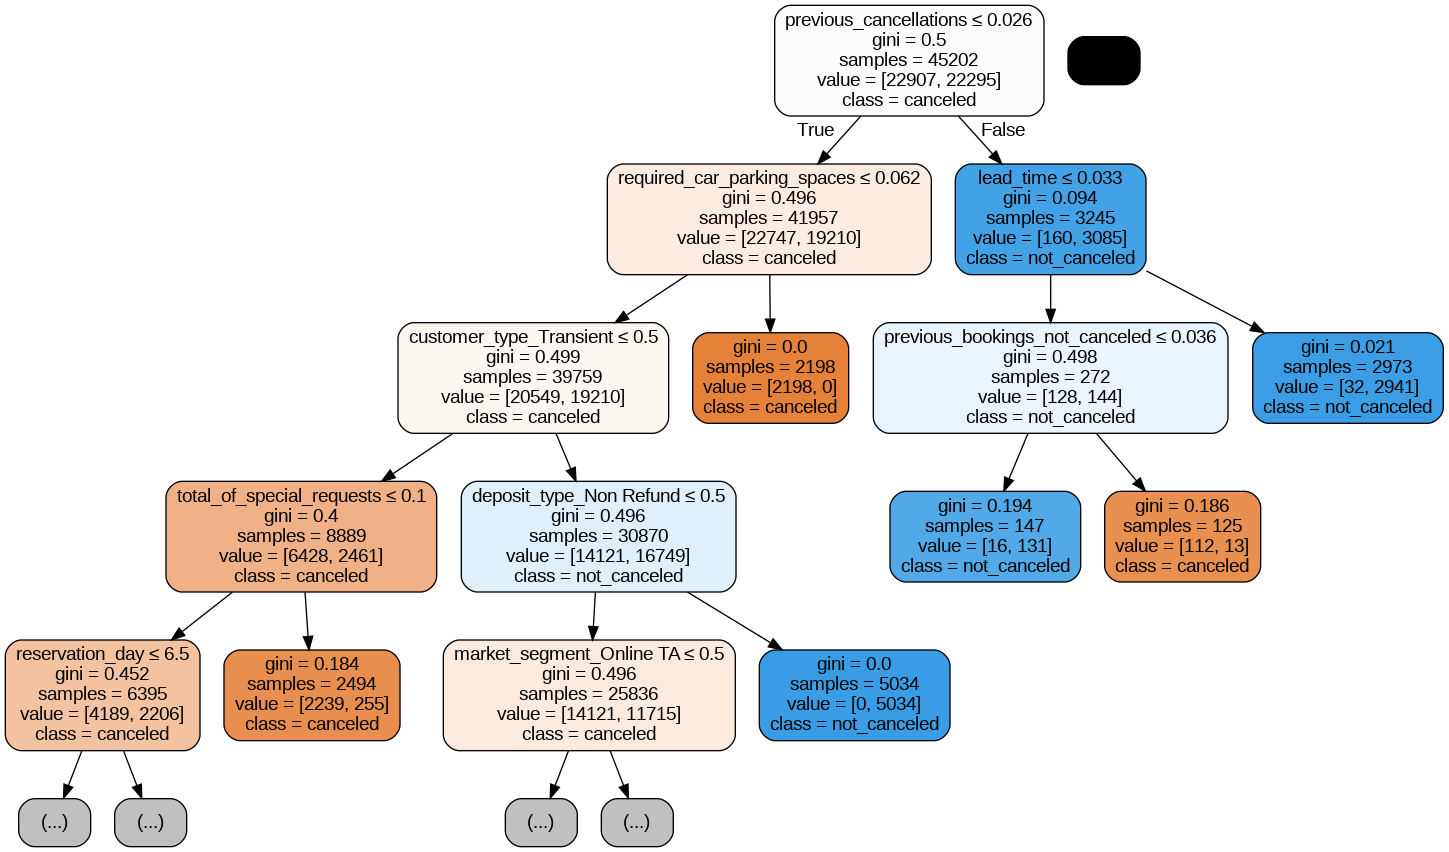

In [80]:
graph_tree(mejor_performance)

# Submit a Kaggle

In [81]:
# Nos traemos el dataset de test sin el ID.
x_sub = df_hotels_test.select_dtypes(exclude=['object'])

# Predecimos con nuestro mejor arbol
y_sub = mejor_performance.predict(x_sub)
y_sub

# Armamos un DF
df_sub = pd.DataFrame({'id': df_hotels_test['id'], 'is_canceled': y_sub})
df_sub

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,0


In [82]:
# Nos guardamos el modelo y el resultado.
import os.path
import time
import json

timestr = time.strftime("%Y%m%d-%H%M%S")
os.mkdir(f'submissions/{timestr}')
df_sub.to_csv(f'submissions/{timestr}/{final_score}.csv', index=False)

#Persisitimos los parametros usados.
with open(f'submissions/{timestr}/params-{final_score}.txt', 'w') as params_file:
     params_file.write(json.dumps(best_params))

# Persistimos el modelo asociado.
model_filename = f'submissions/{timestr}/modelo.pickle'
pickle.dump(mejor_performance, open(model_filename, "wb"))